In [30]:
import uproot as up
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use('seaborn-v0_8-paper')
plt.rcParams["patch.force_edgecolor"] = True

In [31]:
all_feature_df = pd.read_csv("all_features.csv")
all_feature = {col: all_feature_df[col].values for col in all_feature_df.columns}



features_BKG_df = all_feature_df[all_feature_df['Label'] == 0] #Qui c'è sia IBD_fake che BKG_radioactive
features_BKG = {col: features_BKG_df[col].values for col in features_BKG_df.columns}

features_IBD_df = all_feature_df[all_feature_df['Label'] == 1] #Label = 1 sono i VERI ibd
features_IBD = {col: features_IBD_df[col].values for col in features_IBD_df.columns}


In [32]:
print(features_BKG["Label"].shape)
print(features_IBD["Label"].shape)

(1000081,)
(1468385,)


# Cutting algorithm for BOTH IBD and BKG

In [33]:
from numba import njit, prange

In [34]:
@njit(parallel = True) 
#delta time in nanoseconds
#delta radius in mm
def selection(dt,dr,E_pro,E_del, delta_time = 1e6, delta_radius = 1500, min_energy_prompt = 0.7,max_energy_prompt = 12, min_energy_delay = 1.9, max_energy_delay = 2.5, min_energy_delay_carb = 4.4, max_energy_delay_carb = 5.5):
    prompt_columns = np.zeros(dt.shape)
    delay_columns = np.zeros(dt.shape)
    delay_columns_carb = np.zeros(dt.shape)
    for i in prange(dt.shape[0]):
        if dt[i] < delta_time: 
            if dr[i] < delta_radius: 
                if E_pro[i]>= min_energy_prompt and E_pro[i]<= max_energy_prompt:
                    if E_del[i]>= min_energy_delay and E_del[i]<= max_energy_delay:
                        prompt_columns[i] = 1
                        delay_columns[i] = 1
                    if E_del[i]>= min_energy_delay_carb and E_del[i]<= max_energy_delay_carb:
                        prompt_columns[i] = 1
                        delay_columns_carb[i] = 1
    return prompt_columns,delay_columns,delay_columns_carb

### IBD selection, searching for true IBD events

In [35]:
prompt_columns_IBD, delay_columns_IBD, delay_columns_carb_IBD = selection(features_IBD["delta_time"],
                                                                           features_IBD["delta_radius"],
                                                                           features_IBD["E_pro"],
                                                                           features_IBD["E_del"])

In [36]:
print("Venongono selezionati come IBD ", prompt_columns_IBD.sum(),"Su un tot di", prompt_columns_IBD.shape[0])


TP = np.logical_and(features_IBD['Label'] == 1, prompt_columns_IBD == 1)
TN = np.logical_and(features_IBD['Label'] == 0, prompt_columns_IBD == 0)
FN = np.logical_and(features_IBD["Label"] == 1, prompt_columns_IBD == 0)
FP = np.logical_and(features_IBD["Label"] == 0, prompt_columns_IBD == 1) 

print("Efficiency: ", (TP.sum()/(TP.sum()+FN.sum())) * 100)
#Efficiency sono il numero di eventi IBD veri selezionati diviso il numero totale di IBD.
print("Purity: ", (TP.sum()/(TP.sum()+FP.sum())) * 100)	

Venongono selezionati come IBD  1435115.0 Su un tot di 1468385
Efficiency:  97.73424544652799
Purity:  100.0


### BKG selection, searching for fake IBD eventi in BKG_RADIOACTIVITY dataset

In [37]:
prompt_columns_BKG, delay_columns_BKG, delay_columns_carb_BKG = selection(features_BKG["delta_time"][features_BKG["Source"] == 0],
                                                                           features_BKG["delta_radius"][features_BKG["Source"] == 0],
                                                                           features_BKG["E_pro"][features_BKG["Source"] == 0],
                                                                           features_BKG["E_del"][features_BKG["Source"] == 0])

In [38]:
print(prompt_columns_BKG.sum(), prompt_columns_BKG.shape[0])
print(delay_columns_carb_BKG.sum(),delay_columns_carb_BKG.shape[0])

TP = np.logical_and(features_BKG['Label'][features_BKG["Source"] == 0] == 0, prompt_columns_BKG == 0)
TN = np.logical_and(features_BKG['Label'][features_BKG["Source"] == 0] == 1, prompt_columns_BKG == 1)
FN = np.logical_and(features_BKG["Label"][features_BKG["Source"] == 0] == 0, prompt_columns_BKG == 1)
FP = np.logical_and(features_BKG["Label"][features_BKG["Source"] == 0] == 1, prompt_columns_BKG == 0) 

print("Efficiency: ", (TP.sum()/(TP.sum()+FN.sum())) * 100)
print("Purity: ", (TP.sum()/(TP.sum()+FP.sum())) * 100)	

26.0 993457
0.0 993457
Efficiency:  99.9973828761587
Purity:  100.0


# TOTAL Cut Algorithm 

In [39]:
prompt_columns, delay_columns, delay_columns_carb = selection(all_feature["delta_time"],
                                                              all_feature["delta_radius"],
                                                              all_feature["E_pro"],
                                                              all_feature["E_del"])

In [40]:
TP = np.logical_and(all_feature['Label'] == 1, prompt_columns == 1)
TN = np.logical_and(all_feature['Label'] == 0, prompt_columns == 0)
FN = np.logical_and(all_feature["Label"] == 1, prompt_columns == 0)
FP = np.logical_and(all_feature["Label"] == 0, prompt_columns == 1) 

print("Efficiency: ", (TP.sum()/(TP.sum()+FN.sum())) * 100)
print("Purity: ", (TP.sum()/(TP.sum()+FP.sum())) * 100)	

Efficiency:  97.73424544652799
Purity:  99.99742187587098


# Plots

Delta_time and Delta_radius

In [41]:

dataset = pd.concat([pd.DataFrame.from_dict(features_BKG), pd.DataFrame.from_dict(features_IBD)])

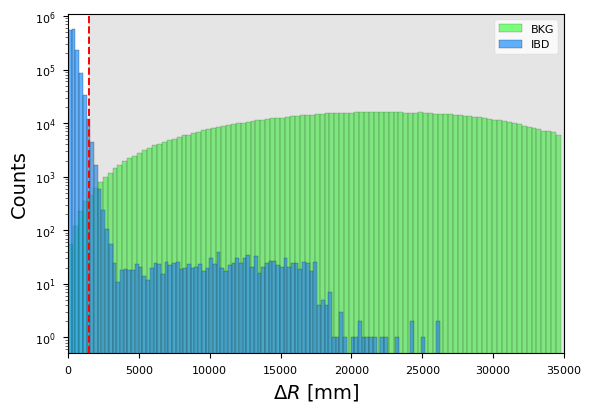

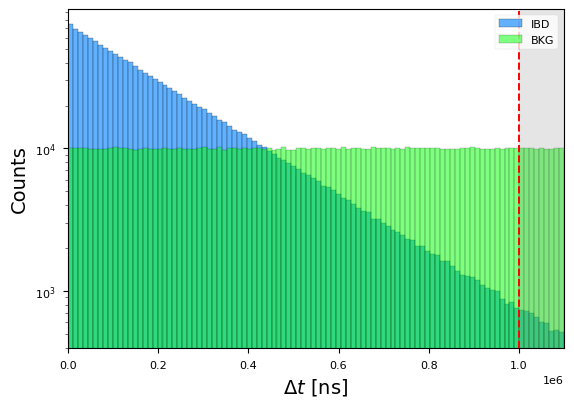

In [107]:

delta_radius_cut = 1500

fig2 = plt.figure()

plt.hist(all_feature["delta_radius"][all_feature['Label'] == 0], bins=100, color='lime', alpha=0.5, label='BKG', log=True)
plt.hist(all_feature["delta_radius"][all_feature['Label'] == 1], bins=100, color='dodgerblue', alpha=0.7, label='IBD', log=True)

plt.axvline(delta_radius_cut, ls='--', c='red')
plt.axvspan(delta_radius_cut,35000, alpha=0.2, color='gray')

plt.xlim(0, 35000)
plt.xlabel(r'$\Delta R$ [mm]', fontsize=14)
plt.ylabel(r'Counts', fontsize=14)
plt.legend(loc='upper right')

plt.savefig('../../../../Latex/Images/Cut/delta_radius.png')
plt.show()

#--------------------------------------------------

delta_time_cut = 1e6
fig2 = plt.figure()


plt.hist(all_feature['delta_time'][all_feature['Label'] == 1],bins=100, color='dodgerblue',alpha = 0.7, label='IBD', log = 'True')
plt.hist(all_feature['delta_time'][all_feature['Label'] == 0],bins=100, color='lime',alpha = 0.5, label='BKG', log = 'True')

plt.axvline(delta_time_cut, ls = '--', c = 'red')
plt.axvspan(delta_time_cut, 5*220e3, alpha=0.2, color='gray')

plt.xlim(0,5*220e3)
plt.xlabel(r'$\Delta t}$ [ns]', fontsize=14)
plt.ylabel(r'Counts', fontsize=14)
plt.legend(loc='upper right')

plt.savefig('../../../../Latex/Images/Cut/delta_time.png')

plt.show()



E_pro

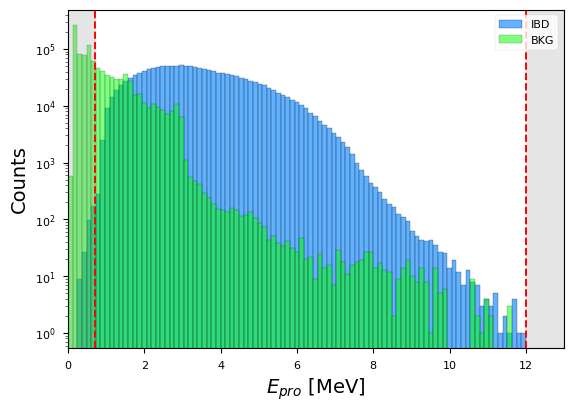

In [108]:
E_pro_cut_1_min = 0.7
E_pro_cut_1_max = 12


fig2 = plt.figure()

plt.hist(all_feature['E_pro'][all_feature['Label'] == 1],np.linspace(0,12,100),color='dodgerblue',alpha = 0.7, label='IBD', log = 'True')
plt.hist(all_feature['E_pro'][all_feature['Label'] == 0],np.linspace(0,12,100), color='lime',alpha = 0.5, label='BKG', log = 'True')
plt.xlim(0,13)

plt.axvline(E_pro_cut_1_min, ls = '--', c = 'red')
plt.axvline(E_pro_cut_1_max, ls = '--', c = 'red')




plt.axvspan(0,E_pro_cut_1_min, alpha=0.2, color='gray')
plt.axvspan(E_pro_cut_1_max, 13, alpha=0.2, color='gray')


plt.xlabel(r'$E_{pro}$ [MeV]', fontsize=14)
plt.ylabel(r'Counts', fontsize=14)
plt.legend(loc='upper right')


plt.savefig('../../../../Latex/Images/Cut/e_pro.png')
plt.show()

E_del

/tmp/ipykernel_280/55603544.py:26: UserWarning: The label '_' of 1.5060750246047971 starts with '_'. It is thus excluded from the legend.
  plt.legend(dataset["E_del"], 'r{E_del_cut_1_min}')
/tmp/ipykernel_280/55603544.py:26: UserWarning: The label '_' of 0.1703789085149765 starts with '_'. It is thus excluded from the legend.
  plt.legend(dataset["E_del"], 'r{E_del_cut_1_min}')
/tmp/ipykernel_280/55603544.py:26: UserWarning: The label '_' of 0.15341396629810333 starts with '_'. It is thus excluded from the legend.
  plt.legend(dataset["E_del"], 'r{E_del_cut_1_min}')
/tmp/ipykernel_280/55603544.py:26: UserWarning: The label '_' of 0.26615193486213684 starts with '_'. It is thus excluded from the legend.
  plt.legend(dataset["E_del"], 'r{E_del_cut_1_min}')
/tmp/ipykernel_280/55603544.py:26: UserWarning: Legend does not support handles for float instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legen

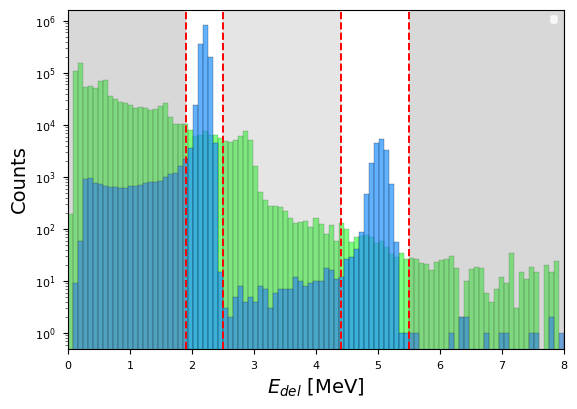

In [106]:
E_del_cut_1_min = 1.9
E_del_cut_1_max = 2.5

E_del_cut_2_min = 4.4
E_del_cut_2_max = 5.5

fig2 = plt.figure()
plt.hist(all_feature['E_del'][all_feature['Label'] == 0],np.linspace(0,8,100), color='lime',alpha = 0.5, label='BKG', log = 'True')
plt.hist(all_feature['E_del'][all_feature['Label'] == 1],np.linspace(0,8,100), color='dodgerblue',alpha = 0.7, label='IBD', log = 'True')
plt.xlim(0,8)

plt.axvline(E_del_cut_1_min, ls = '--', c = 'red')
plt.axvline(E_del_cut_1_max, ls = '--', c = 'red')

plt.axvline(E_del_cut_2_min, ls = '--', c = 'red')
plt.axvline(E_del_cut_2_max, ls = '--', c = 'red')


plt.axvspan(0,E_del_cut_1_min, alpha=0.2, color='gray')
plt.axvspan(E_del_cut_1_max, E_del_cut_2_min, alpha=0.2, color='gray')
plt.axvspan(E_del_cut_2_max, 8, alpha=0.2, color='gray')


plt.xlabel(r'$E_{del}$ [MeV]', fontsize=14)
plt.ylabel(r'Counts', fontsize=14)
plt.legend(dataset["E_del"], 'r{E_del_cut_1_min}')

plt.savefig('../../../../Latex/Images/Cut/e_del.png')
plt.show()
